# EECS 442 Homework 4: Fashion-MNIST Classification
In this part, you will implement and train Convolutional Neural Networks (ConvNets) in PyTorch to classify images. Unlike HW4 Secion 1, backpropagation is automatically inferred by PyTorch, so you only need to write code for the forward pass.

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) David FOUHEY, #12345678

**Your Answer:**   
Hello EECS442 #12345678

## Setup

In [9]:
# Run the command in the terminal if it failed on local Jupyter Notebook, remove "!" before each line
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split

In [11]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'

Using the GPU. You are good to go!


## Loading Dataset
The dataset we use is Fashion-MNIST dataset, which is available at https://github.com/zalandoresearch/fashion-mnist and in torchvision.datasets. Fashion-MNIST has 10 classes, 60000 training+validation images (we have splitted it to have 50000 training images and 10000 validation images, but you can change the numbers), and 10000 test images.

In [12]:
# Load the dataset and train, val, test splits
print("Loading datasets...")
# Transform from [0,255] uint8 to [0,1] float,
# then normalize to zero mean and unit variance
FASHION_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.2859], [0.3530]) 
                    ])
FASHION_trainval = datasets.FashionMNIST('.', download=True, train=True,
                                         transform=FASHION_transform)
FASHION_train = Subset(FASHION_trainval, range(50000))
FASHION_val = Subset(FASHION_trainval, range(50000, 60000))
FASHION_test = datasets.FashionMNIST('.', download=True, train=False,
                                     transform=FASHION_transform)
print("Done!")

Loading datasets...
Done!


Now, we will create the dataloder for train, val and test dataset. You are free to experiment with different batch sizes.

In [13]:
# Create dataloaders
##############################################################################
# TODO: Experiment with different batch sizes                                #
##############################################################################
batch_size=32
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################
trainloader = DataLoader(FASHION_train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(FASHION_val, batch_size=batch_size, shuffle=True)
testloader = DataLoader(FASHION_test, batch_size=batch_size, shuffle=True)

## Model
Initialize your model and experiment with with different optimizers, parameters (such as learning rate) and number of epochs.

In [14]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        ##############################################################################
        # TODO: Design your own network, define layers here.                          #
        # Here We provide a sample of two-layer fc network from HW4 Part3.           #
        # Your solution, however, should contain convolutional layers.               #
        # Refer to PyTorch documentations of torch.nn to pick your layers.           #
        # (https://pytorch.org/docs/stable/nn.html)                                  #
        # Some common choices: Linear, Conv2d, ReLU, MaxPool2d, AvgPool2d, Dropout   #
        # If you have many layers, use nn.Sequential() to simplify your code         #
        ##############################################################################
        # from 28x28 input image to hidden layer of size 256
        self.fc1 = nn.Linear(28*28, 256) 
        # from hidden layer to 10 class scores
        self.fc2 = nn.Linear(256,10) 
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
  
    def forward(self, x):
        ##############################################################################
        # TODO: Design your own network, implement forward pass here                 # 
        ##############################################################################
        x = x.to(device)
        # Flatten each image in the batch
        x = x.view(-1,28*28) 
        x = self.fc1(x)
        # No need to define self.relu because it contains no parameters
        relu = nn.ReLU() 
        x = relu(x)
        x = self.fc2(x)
        # The loss layer will be applied outside Network class
        return x
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

model = Network().to(device)
criterion = nn.CrossEntropyLoss() # Specify the loss layer
print('Your network:')
print(summary(model, (1,28,28), device=device)) # visualize your model

##############################################################################
# TODO: Modify the lines below to experiment with different optimizers,      #
# parameters (such as learning rate) and number of epochs.                   #
##############################################################################
# Set up optimization hyperparameters
learning_rate = 1e-3
weight_decay = 1e-5
num_epoch = 15  # TODO: Choose an appropriate number of training epochs
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                       weight_decay=weight_decay) # Try different optimizers
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                   [-1, 10]           2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.78
Estimated Total Size (MB): 0.78
----------------------------------------------------------------
None


Run the cell below to start your training, we expect you to achieve over **85%** on the test set. A valid solution that meet the requirement take no more than **10 minutes** on normal PC Intel core CPU setting. If your solution takes too long to train, try to simplify your model or reduce the number of epochs.

In [15]:
%%time
def train(model, trainloader, valloader, num_epoch=10):  # Train the model
    print("Start training...")
    trn_loss_hist = []
    trn_acc_hist = []
    val_acc_hist = []
    model.train()  # Set the model to training mode
    for i in range(num_epoch):
        running_loss = []
        print('-----------------Epoch = %d-----------------' % (i+1))
        for batch, label in tqdm(trainloader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad()  # Clear gradients from the previous iteration
            # This will call Network.forward() that you implement
            pred = model(batch)
            loss = criterion(pred, label)  # Calculate the loss
            running_loss.append(loss.item())
            loss.backward()  # Backprop gradients to all tensors in the network
            optimizer.step()  # Update trainable weights
        print("\n Epoch {} loss:{}".format(i+1, np.mean(running_loss)))

        # Keep track of training loss, accuracy, and validation loss
        trn_loss_hist.append(np.mean(running_loss))
        trn_acc_hist.append(evaluate(model, trainloader))
        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, valloader))
    print("Done!")
    return trn_loss_hist, trn_acc_hist, val_acc_hist


def evaluate(model, loader):  # Evaluate accuracy on validation / test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    with torch.no_grad():  # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred, dim=1) == label).sum().item()
        acc = correct/len(loader.dataset)
        print("\n Evaluation accuracy: {}".format(acc))
        return acc


trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, trainloader,
                                                  valloader, num_epoch)

##############################################################################
# TODO: Note down the evaluation accuracy on test set                        #
##############################################################################
print("\n Evaluate on test set")
evaluate(model, testloader)

Start training...
-----------------Epoch = 1-----------------


100%|██████████| 1563/1563 [00:22<00:00, 69.58it/s] 



 Epoch 1 loss:0.4585695344661568


100%|██████████| 1563/1563 [00:12<00:00, 121.67it/s]



 Evaluation accuracy: 0.87614

 Evaluate on validation set...


100%|██████████| 313/313 [00:02<00:00, 130.24it/s]



 Evaluation accuracy: 0.8643
-----------------Epoch = 2-----------------


100%|██████████| 1563/1563 [00:15<00:00, 100.33it/s]



 Epoch 2 loss:0.3532718810385721


100%|██████████| 1563/1563 [00:12<00:00, 120.85it/s]



 Evaluation accuracy: 0.88534

 Evaluate on validation set...


100%|██████████| 313/313 [00:02<00:00, 128.32it/s]



 Evaluation accuracy: 0.8696
-----------------Epoch = 3-----------------


100%|██████████| 1563/1563 [00:15<00:00, 101.34it/s]



 Epoch 3 loss:0.31660874798340977


100%|██████████| 1563/1563 [00:13<00:00, 113.55it/s]



 Evaluation accuracy: 0.88912

 Evaluate on validation set...


100%|██████████| 313/313 [00:02<00:00, 122.84it/s]



 Evaluation accuracy: 0.8675
-----------------Epoch = 4-----------------


100%|██████████| 1563/1563 [00:15<00:00, 101.92it/s]



 Epoch 4 loss:0.2921584684804549


100%|██████████| 1563/1563 [00:13<00:00, 120.10it/s]



 Evaluation accuracy: 0.89992

 Evaluate on validation set...


100%|██████████| 313/313 [00:02<00:00, 128.20it/s]



 Evaluation accuracy: 0.8766
-----------------Epoch = 5-----------------


100%|██████████| 1563/1563 [00:14<00:00, 104.90it/s]



 Epoch 5 loss:0.2750658560270159


100%|██████████| 1563/1563 [00:12<00:00, 122.11it/s]



 Evaluation accuracy: 0.91014

 Evaluate on validation set...


100%|██████████| 313/313 [00:02<00:00, 128.48it/s]



 Evaluation accuracy: 0.8826
-----------------Epoch = 6-----------------


100%|██████████| 1563/1563 [00:15<00:00, 100.31it/s]



 Epoch 6 loss:0.2540264533438213


100%|██████████| 1563/1563 [00:13<00:00, 116.32it/s]



 Evaluation accuracy: 0.92016

 Evaluate on validation set...


100%|██████████| 313/313 [00:02<00:00, 131.63it/s]



 Evaluation accuracy: 0.8871
-----------------Epoch = 7-----------------


100%|██████████| 1563/1563 [00:14<00:00, 105.07it/s]



 Epoch 7 loss:0.2420510891527033


100%|██████████| 1563/1563 [00:12<00:00, 121.83it/s]



 Evaluation accuracy: 0.91124

 Evaluate on validation set...


100%|██████████| 313/313 [00:02<00:00, 134.23it/s]



 Evaluation accuracy: 0.8766
-----------------Epoch = 8-----------------


100%|██████████| 1563/1563 [00:15<00:00, 102.12it/s]



 Epoch 8 loss:0.23085045551205494


100%|██████████| 1563/1563 [00:12<00:00, 122.31it/s]



 Evaluation accuracy: 0.9105

 Evaluate on validation set...


100%|██████████| 313/313 [00:02<00:00, 129.58it/s]



 Evaluation accuracy: 0.8715
-----------------Epoch = 9-----------------


100%|██████████| 1563/1563 [00:14<00:00, 105.73it/s]



 Epoch 9 loss:0.22060375944285232


100%|██████████| 1563/1563 [00:12<00:00, 121.77it/s]



 Evaluation accuracy: 0.92546

 Evaluate on validation set...


100%|██████████| 313/313 [00:02<00:00, 129.83it/s]



 Evaluation accuracy: 0.885
-----------------Epoch = 10-----------------


100%|██████████| 1563/1563 [00:15<00:00, 103.37it/s]



 Epoch 10 loss:0.21156828746948003


100%|██████████| 1563/1563 [00:13<00:00, 120.15it/s]



 Evaluation accuracy: 0.92994

 Evaluate on validation set...


100%|██████████| 313/313 [00:03<00:00, 102.32it/s]



 Evaluation accuracy: 0.8846
-----------------Epoch = 11-----------------


100%|██████████| 1563/1563 [00:16<00:00, 94.18it/s] 



 Epoch 11 loss:0.20222050154323065


100%|██████████| 1563/1563 [00:12<00:00, 121.58it/s]



 Evaluation accuracy: 0.93382

 Evaluate on validation set...


100%|██████████| 313/313 [00:02<00:00, 125.89it/s]



 Evaluation accuracy: 0.8854
-----------------Epoch = 12-----------------


100%|██████████| 1563/1563 [00:15<00:00, 100.30it/s]



 Epoch 12 loss:0.1948653828049995


100%|██████████| 1563/1563 [00:13<00:00, 116.43it/s]



 Evaluation accuracy: 0.92868

 Evaluate on validation set...


100%|██████████| 313/313 [00:02<00:00, 114.89it/s]



 Evaluation accuracy: 0.8806
-----------------Epoch = 13-----------------


100%|██████████| 1563/1563 [00:14<00:00, 104.49it/s]



 Epoch 13 loss:0.18616086909141075


100%|██████████| 1563/1563 [00:12<00:00, 122.92it/s]



 Evaluation accuracy: 0.93878

 Evaluate on validation set...


100%|██████████| 313/313 [00:02<00:00, 118.09it/s]



 Evaluation accuracy: 0.8871
-----------------Epoch = 14-----------------


100%|██████████| 1563/1563 [00:15<00:00, 103.60it/s]



 Epoch 14 loss:0.1775419522358089


100%|██████████| 1563/1563 [00:12<00:00, 121.28it/s]



 Evaluation accuracy: 0.93402

 Evaluate on validation set...


100%|██████████| 313/313 [00:02<00:00, 130.43it/s]



 Evaluation accuracy: 0.8845
-----------------Epoch = 15-----------------


100%|██████████| 1563/1563 [00:14<00:00, 106.08it/s]



 Epoch 15 loss:0.1718742694489429


100%|██████████| 1563/1563 [00:12<00:00, 123.63it/s]



 Evaluation accuracy: 0.94116

 Evaluate on validation set...


100%|██████████| 313/313 [00:02<00:00, 132.59it/s]



 Evaluation accuracy: 0.8872
Done!

 Evaluate on test set


100%|██████████| 313/313 [00:03<00:00, 103.79it/s]


 Evaluation accuracy: 0.884
CPU times: user 7min 37s, sys: 3.97 s, total: 7min 41s
Wall time: 7min 52s


0.884

Once your training is complete, run the cell below to visualize the training and validation accuracies across iterations.

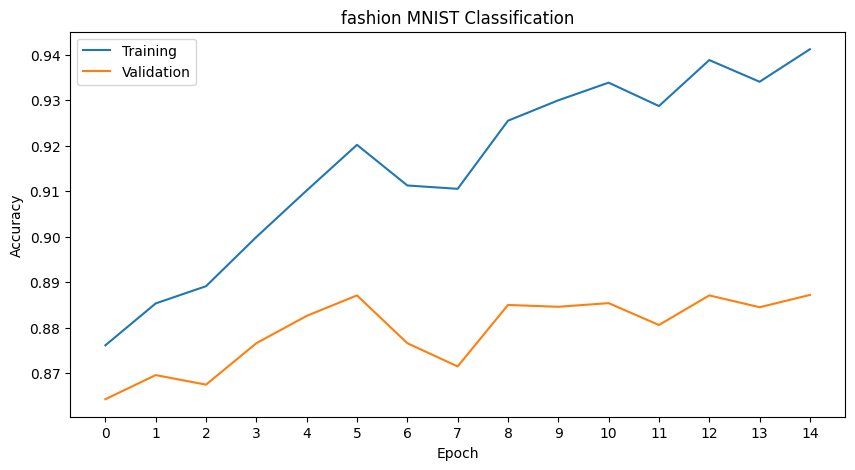

In [16]:
##############################################################################
# TODO: Submit the accuracy plot                                             #
##############################################################################
# visualize the training / validation accuracies
x = np.arange(num_epoch)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, trn_acc_hist)
plt.plot(x, val_acc_hist)
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('fashion MNIST Classification')
plt.gcf().set_size_inches(10, 5)
plt.savefig('part1.png', dpi=300)
plt.show()